<a href="https://colab.research.google.com/github/romainlm7/bank_customer_churn/blob/main/bank_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd 
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [4]:
url = 'https://raw.githubusercontent.com/romainlm7/churn_bank/main/Churn_Modelling.csv'
df = pd.read_csv(url)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploration et préparation des données 

In [5]:
dataframe = df.copy()
# suppression des variables non pertinentes 
df.drop(['RowNumber','CustomerId','Surname'],axis=1, inplace=True)
# on renomme la variable dépendante 
df.rename(columns={'Exited':'Churn'}, inplace=True)

In [6]:
df.shape

(10000, 11)

In [27]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Churn                int64
dtype: object

In [ ]:
df.isnull().sum() # aucune valeur manquante 

In [ ]:
df.Geography.unique() # 3 pays : France, Spain, Germany 

### Statistiques descriptives 

In [ ]:
df.Churn.value_counts(normalize=True) # 20% ont churn 

In [ ]:
for col in df.columns: 
    print(col)

In [10]:
df[['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


Age                0.285323
IsActiveMember     0.156128
Balance            0.118533
NumOfProducts      0.047820
CreditScore        0.027094
Tenure             0.014001
EstimatedSalary    0.012097
HasCrCard          0.007138
Name: Churn, dtype: float64

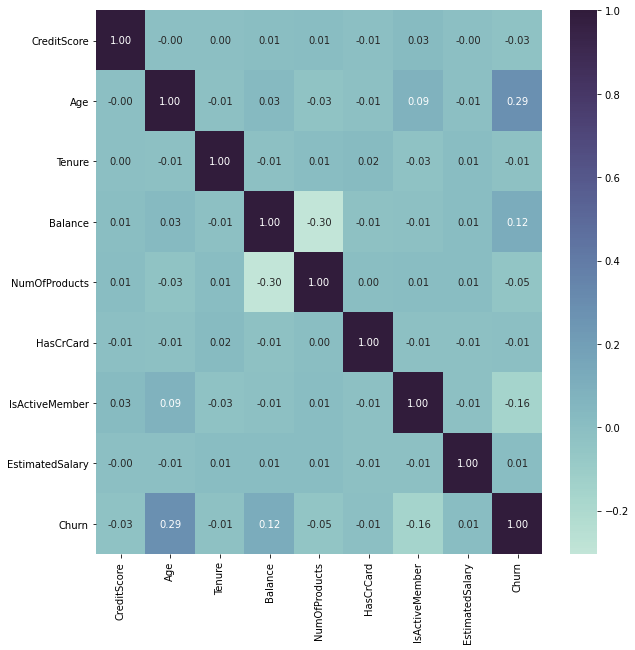

In [11]:
# correlation 
fig, ax = plt.subplots(figsize=(10,10))
color = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(df.corr(), annot=True, fmt=".2f",ax=ax,cmap=color)
#plt.show()

churn_corr = df.corr()["Churn"]
churn_corr.abs().sort_values(ascending=False)[1:]
# Age a la plus forte correlation avec la variable dépendante 

<Figure size 1080x1080 with 0 Axes>

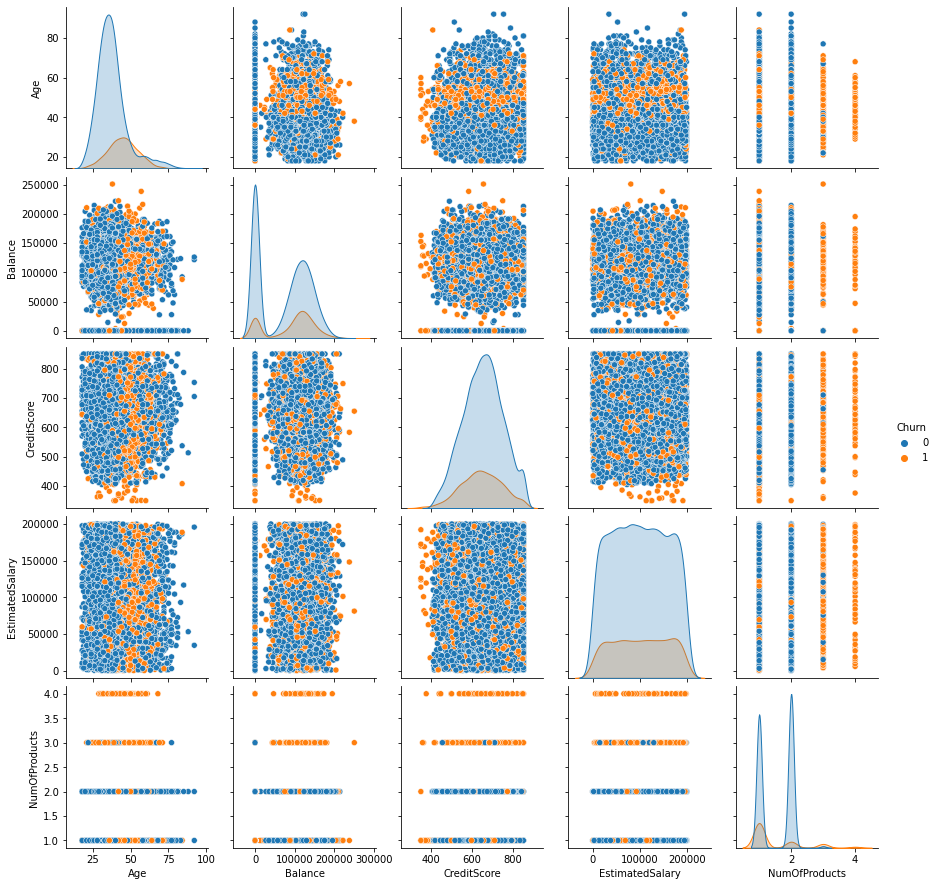

In [12]:
plt.figure(figsize=(15,15))
sns.pairplot(df, vars=df[['Age','Balance','CreditScore','EstimatedSalary','NumOfProducts']], hue="Churn")

# Pour Age, la plupart des churn se distribuent autour de 40 et les non churn autour de 30 
# Pour Balance, Credit_score et EstimatedSalary, les distributions churn/no churn sont très proches  
# On n'oberve pas d'outliers 


In [13]:
len(df[(df['NumOfProducts']==4) & (df['Churn']==0)])
# lorsque NumOfProducts=4 => churn = 1

0

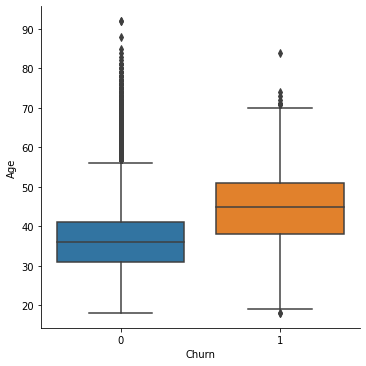

In [14]:
sns.catplot(x='Churn',y='Age',kind='box',data=df)

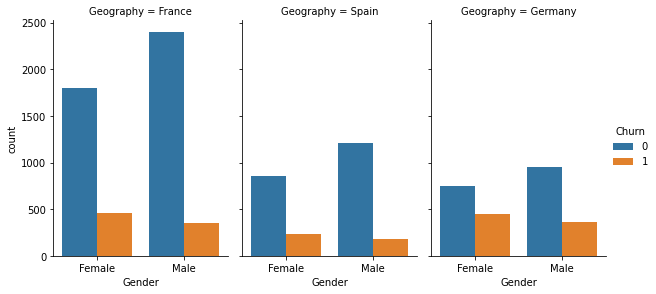

In [15]:
sns.catplot(x="Gender", hue="Churn", col="Geography",
                data=df, kind="count",
                height=4, aspect=.7);

In [16]:
# Répartition de churn par pays et sexes. 
namesgrouped = df[["Geography", "Gender", "Churn","CreditScore"]].groupby(["Geography", "Gender", "Churn"]).sum()
namesgrouped.groupby(level=[0,1]).apply(lambda g: g / g.sum())

# on remarque que le pourcentage de churn pour les femmes et les hommes est plus élevé en Allemagne par rapport aux autres pays: 
# Femme : GER:37% , FR:20%, SP:21%
# Homme : GER:27% , FR:13%, SP:13% 

CreditScore
Geography Gender Churn             
France    Female 0         0.798207
                 1         0.201793
          Male   0         0.874970
                 1         0.125030
Germany   Female 0         0.625834
                 1         0.374166
          Male   0         0.724453
                 1         0.275547
Spain     Female 0         0.789964
                 1         0.210036
          Male   0         0.869040
                 1         0.130960

## Elaboration et évaluation des modèles 

In [17]:
df = pd.get_dummies(df, columns=["Geography","Gender"]) # création de variables dichotomiques 

In [18]:
df.drop(['Geography_Spain','Gender_Female'],axis=1, inplace=True) # supprime une des variables  

In [19]:
## Let's define X and Y

X = df.drop(labels=["Churn"], axis=1)
y = df['Churn'] 
features = X.columns

In [20]:
## Scaling features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns=features

In [21]:
# split train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [22]:
# nous avons 20% de churn et 80% de non churn 
# mise en place du sur-échantillonage (oversampling)
train_data = pd.concat([X_train, y_train], axis=1)

In [23]:
# separate minority and majority classes
active = train_data[train_data.Churn==0]
inactive = train_data[train_data.Churn==1]

In [24]:
from sklearn.utils import resample
# upsample minority
inactive_upsampled = resample(inactive,
 n_samples=len(active), 
 random_state=27) 
# combine majority and upsampled minority
upsampled = pd.concat([active, inactive_upsampled])
# check new class counts
upsampled.Churn.value_counts()

1    6356
0    6356
Name: Churn, dtype: int64

In [25]:

X_train = upsampled.drop(labels=["Churn"], axis=1)
y_train = upsampled["Churn"]

In [28]:
### K_fold
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# On divise les données en parties «kfolds» pour une validation croisée,
# On utilise le shuffle pour assurer une distribution aléatoire des données:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Prétraitement, ajustement, prédiction et notation pour chaque modèle::
for name, model in base_models:
    
    model_steps = Pipeline(steps=[('model', model)])
    
    # obtenir un cross validation pour chaque modèle:
    cv_results = cross_val_score(model_steps, 
                                 X_train, y_train, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuarcy score: 0.9123 +/- 0.0084 (std) min: 0.8987, max: 0.9207
RF_model cross validation accuarcy score: 0.9473 +/- 0.0035 (std) min: 0.9424, max: 0.9506
LR_model cross validation accuarcy score: 0.7025 +/- 0.0039 (std) min: 0.696, max: 0.7067
XGB_model cross validation accuarcy score: 0.7938 +/- 0.0071 (std) min: 0.7823, max: 0.7999


## Let's train the full Random Forest model

In [30]:
# RF meilleur accuracy score 
model_rf_full = RandomForestClassifier(random_state=42,n_jobs=-1)
model_rf_full.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
y_pred_rf= model_rf_full.predict(X_test)

In [32]:
y_pred_proba_rf = model_rf_full.predict_proba(X_test)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1607
           1       0.68      0.54      0.60       393

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



### Confusion Matrix

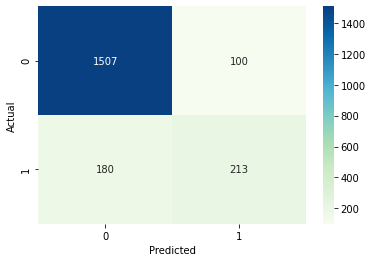

In [34]:
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_score, recall_score, f1_score, accuracy_score

cf_matrix = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cf_matrix, annot=True, cmap="GnBu", fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

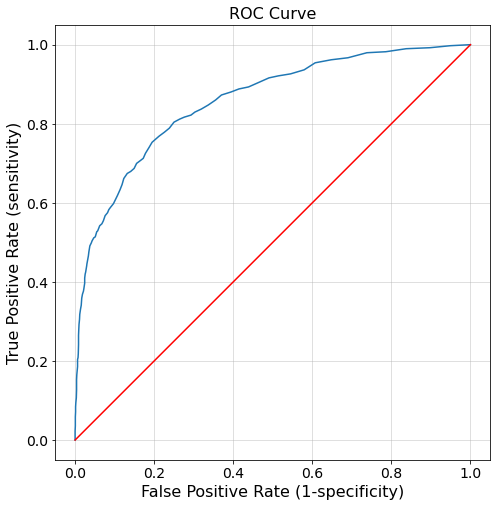

In [37]:
#@title ROC curve
# find probability for each prediction
prob_rf=model_rf_full.predict_proba(X_test)[:,1]

# look at ROC curve, which gives us the false and true positive predictions
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test, prob_rf)


# Graphique:

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color="red")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate (1-specificity)", fontsize=16)
plt.ylabel("True Positive Rate (sensitivity)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [38]:
#@title Scores
# Looking at the area under the curve
print("AUC Score = ", round(roc_auc_score(y_test, y_pred_rf),2))
# Looking at the accuracy score
print( "What proportion of predictions the model classified correctly?\n Accuracy Score = ", round(accuracy_score(y_test, y_pred_rf),2))
# Rate of churn in sample, to compare with 
i=0
for a in y_test:
  if a==1:
    i+=1
i/len(y_test)
# Looking at the precision score
print("What proportion of positive identifications was actually correct?\n Precision Score = ", round(precision_score(y_test, y_pred_rf),2), " It beat the natural proportion of positive instances in the test sample (", round(i/len(y_test),2), ")!")
# Looking at the recall score
print("What proportion of actual positives was identified correctly?\n Recall/Sensitivity Score = ", round(recall_score(y_test, y_pred_rf),2))
#looking at the f1_score
print("F1 Score = ", round(f1_score(y_test, y_pred_rf),2))

AUC Score =  0.74
What proportion of predictions the model classified correctly?
 Accuracy Score =  0.86
What proportion of positive identifications was actually correct?
 Precision Score =  0.68  It beat the natural proportion of positive instances in the test sample ( 0.2 )!
What proportion of actual positives was identified correctly?
 Recall/Sensitivity Score =  0.54
F1 Score =  0.6


Text(0, 0.5, 'Feature importance')

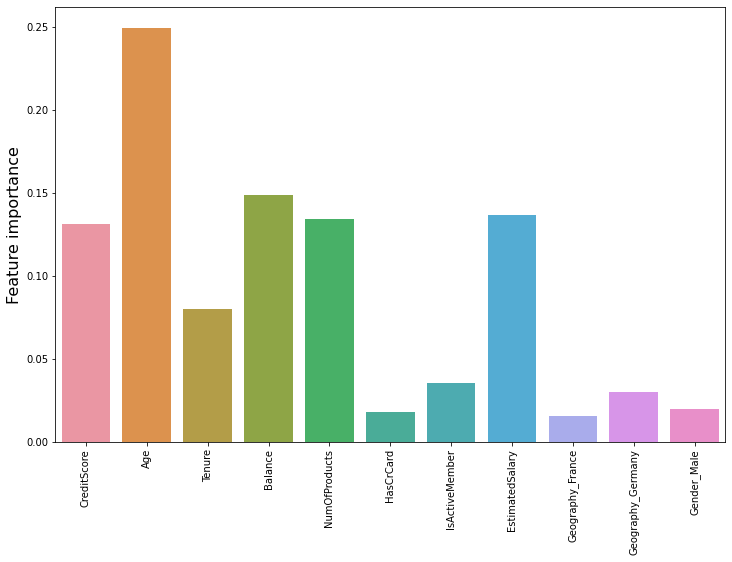

In [39]:
coef = pd.DataFrame(list(zip(features, model_rf_full.feature_importances_)))

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=coef[0], y=coef[1])
ax.set_xticklabels(coef[0], rotation=90);
plt.xlabel("")
plt.ylabel("Feature importance", size=16)



# Age est la variable la plus importante pour prédire le churn, 
# vient ensuite Balance, EstimatedSalary, NumOfProducts et CreditScore avec une importance assez proche 